# Classifier
ReLU activation, 4 layers, 100 neurons per layer
Validation score use ensemble of 10 models weighted by loss

### TODO:

- What metrics to use during training?
- Which plots are needed?


### Import modules

In [1]:
%matplotlib inline
from __future__ import division
import tensorflow as tf
import pandas as pd
import sys
import os
sys.path.append('../')
from Modules.Basics import *
from Modules.Class_Basics import *
from keras.models import load_model

#dirLoc = '../Data/'
#name = "weights/ReLU_Baseline_CLR_AsimovLoss"
#dirLoc = '../Data_3Fold/'
#name = "weights/ReLU_Baseline_CLR_AsimovLoss_3Fold"
dirLoc = '../Data_SUSY/'
name = "weights/ReLU_Baseline_CLR_AsimovLoss_SUSY"

name_pretrain = name.replace('weights/', 'train_weights/PRETRAIN_')

Using TensorFlow backend.


## Prep SUSY data
    (analog zu Data_Import.py)

In [2]:
from Modules.Data_Import import prepareSample, getPreProcPipes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

nFolds = 3 # is almost the same as the train-test split that Adam used of 30%
# features same as Adam used
features = [
    'HT','MET','MT','MT2W','n_jet',
    'n_bjet','sel_lep_pt0','sel_lep_eta0','sel_lep_phi0',
    'selJet_phi0','selJet_pt0','selJet_eta0','selJet_m0',
    'selJet_phi1','selJet_pt1','selJet_eta1','selJet_m1',
    'selJet_phi2','selJet_pt2','selJet_eta2','selJet_m2',
]

df = pd.read_pickle('../../dfs/combinedleonid.pkl')
df.drop(columns=list(k for k in df.keys() if k not in features+['signal']), inplace=True)
df.rename(index=str, columns={"signal": "gen_target"}, inplace=True)
df['EventId'] = df.index.tolist()
df['gen_weight_original'] = 1.
df['gen_weight'] = 1.
df.fillna(0,inplace=True)

# 30% test, 16% validation, rest training
train, test = train_test_split(df, test_size=0.3, random_state=492)
# train, val = train_test_split(train, test_size=0.2, random_state=492)

# a thing that's applied in Higgs analysis...
# convertData(trainingData, rotate, cartesian)
# convertData(test, rotate, cartesian)

data = {
    'train': train[features + ['gen_target', 'gen_weight', 'gen_weight_original']],
    #'val': test[features + ['gen_target', 'gen_weight', 'gen_weight_original']],
    'test': test,
    'features': features
}

# rest copied from Modules.Data_Import.runDataImport:
inputPipe, _ = getPreProcPipes(normIn=True)
inputPipe.fit(data['train'][data['features']].values.astype('float32'))
with open(dirLoc + 'inputPipe.pkl', 'wb') as fout:
    pickle.dump(inputPipe, fout)

prepareSample(data['train'], 'train', inputPipe, False, nFolds, data['features'], dirLoc)
#prepareSample(data['val']  , 'val', inputPipe, False, nFolds, data['features'], dirLoc)
prepareSample(data['test'] , 'test', inputPipe, False, nFolds, data['features'], dirLoc)

with open(dirLoc + 'features.pkl', 'wb') as fout:
    pickle.dump(data['features'], fout)

('Running', 'train')
('Saving fold:', 0, 'of', 466667, 'events')
('Saving fold:', 1, 'of', 466667, 'events')
('Saving fold:', 2, 'of', 466666, 'events')
('Running', 'test')
('Saving fold:', 0, 'of', 200001, 'events')
('Saving fold:', 1, 'of', 200000, 'events')
('Saving fold:', 2, 'of', 199999, 'events')


## Options

In [2]:
with open(dirLoc + 'features.pkl', 'rb') as fin:
    classTrainFeatures = pickle.load(fin)

In [3]:
nSplits = 10
patience = 50
maxEpochs = 200
preTrainMaxEpochs = 10

ensembleSize = nSplits
ensembleMode = 'loss'

compileArgs = {'loss':'binary_crossentropy', 'optimizer':'adam'}
trainParams = {'epochs' : 1, 'batch_size' : 256, 'verbose' : 0}
modelParams = {'version':'modelRelu', 'nIn':len(classTrainFeatures), 'compileArgs':compileArgs, 'mode':'classifier'}

plot_while_training = True

print ("\nTraining on", len(classTrainFeatures), "features:", [var for var in classTrainFeatures])


# b = 100000  # test
# t = 250000  # training
# v = 450000  # test

# sig weight sum:  1383.97719575 in 550000
# bkg weight sum:  821999.696026 in 550000

# expected signal and background numbers
lumi=30.
s_exp=228.195*0.14*lumi #leonid's number
b_exp=844000.*8.2e-4*lumi #cross section of ttbar sample in fb times efficiency measured by Marco

print ('_S%.2e'%s_exp).replace('.', 'd').replace('+','p').replace('-','m')
print ('_B%.2e'%b_exp).replace('.', 'd').replace('+','p').replace('-','m')

new_loss_functions = get_losses_dict([0.001, 0.1, 0.3, 0.5], s_exp, b_exp)

def plotLoss(history):
    val_loss = history['val_loss']
    plt.plot(history['val_train_loss'],label='train')
    plt.plot(val_loss,label='test')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    if max(val_loss) > 20*min(val_loss) and min(val_loss)>0:
        plt.yscale('log')
    plt.legend(loc='best')
#    plt.savefig(os.path.join(self.output,'lossEvolution.pdf'))
#    plt.clf()
    plt.show()

('\nTraining on', 21, 'features:', ['HT', 'MET', 'MT', 'MT2W', 'n_jet', 'n_bjet', 'sel_lep_pt0', 'sel_lep_eta0', 'sel_lep_phi0', 'selJet_phi0', 'selJet_pt0', 'selJet_eta0', 'selJet_m0', 'selJet_phi1', 'selJet_pt1', 'selJet_eta1', 'selJet_m1', 'selJet_phi2', 'selJet_pt2', 'selJet_eta2', 'selJet_m2'])
_S9d58ep02
_B2d08ep04


## Import data

In [4]:
trainData          = BatchYielder(h5py.File(dirLoc + 'train.hdf5', "r"))
trainDataTargetMod = BatchYielderTargetMod(h5py.File(dirLoc + 'train.hdf5', "r"))
nSplits = trainData.nFolds

## Train classifier
    (define model parameters + and train)

In [5]:
def _get_s_b(s_exp, b_exp, y_true, y_pred):

   # unfold encoded weights
    weights = K.abs(y_true)
    s_weights = (weights + y_true)/2.
    b_weights = (weights - y_true)/2.

    s_exp_weight = s_exp/(K.abs(K.sum(s_weights)))
    b_exp_weight = b_exp/(K.abs(K.sum(b_weights)))

    #y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1 - K.epsilon()) # target y_pred from below and above by epsilon 

#     s_exp = K.print_tensor(s_exp, 's_exp = ')
#     b_exp = K.print_tensor(b_exp, 'b_exp = ')
#     y_pred = K.print_tensor(y_pred, 'y_pred = ')
#     y_true = K.print_tensor(y_true, 'y_true = ')
#     s_weights = K.print_tensor(s_weights, 's_weights = ')
#     b_weights = K.print_tensor(b_weights, 'b_weights = ')
#     s_exp_weight = K.print_tensor(s_exp_weight, 's_exp_weight = ')
#     b_exp_weight = K.print_tensor(b_exp_weight, 'b_exp_weight = ')

    s = s_exp_weight * K.sum(y_pred * s_weights)
    b = b_exp_weight * K.sum(y_pred * b_weights)
    return s, b

def significanceLoss(s_exp=None, b_exp=None):
    '''Define a loss function that calculates the significance based on fixed
    expected signal and expected background yields for a given batch size

    s_exp and b_exp are the number of recorded signal and background events,
    respectively (xsec*lumi).'''

    #@_patch_with_weights
    def sigLoss(y_true, y_pred):
        s, b = _get_s_b(s_exp, b_exp, y_true, y_pred)
        s = K.print_tensor(s, 's=')
        b = K.print_tensor(b, 'b=')
        #loss = K.log( b/(s*s) )
        loss = b/(s*s)
        #loss = - K.log(s*s/b)
        #loss = - s*s/b
        loss = K.print_tensor(loss, "loss=")
        loss = K.print_tensor(loss, "loss2=")
        return loss

    return sigLoss

def asimovSignificanceLossInvert(syst_factr, s_exp=None, b_exp=None):
    '''Define a loss function that calculates the significance based on fixed
    expected signal and expected background yields for a given batch size

    s_exp and b_exp are the number of recorded signal and background events,
    respectively (xsec*lumi).'''

    #@_patch_with_weights
    def asimovSigLossInvert(y_true, y_pred):        
        s, b = _get_s_b(s_exp, b_exp, y_true, y_pred)
        b2 = b*b
        syst = syst_factr * b
        syst2 = syst*syst
        #s=K.print_tensor(s, 's=')
        
        #b=K.print_tensor(b, 'b=')
        
        #syst=K.print_tensor(syst, 'syst=')
        
        loss = 0.5/((s+b) * K.log((s+b)*(b+syst2)/(b2+(s+b)*syst2))-b2/syst2 * K.log(1+syst2*s/(b*(b+syst2))) )
        loss = -K.log(((s+b) * K.log((s+b)*(b+syst2)/(b2+(s+b)*syst2))-b2/syst2 * K.log(1+syst2*s/(b*(b+syst2))) ))
        
        loss=K.print_tensor(loss, 'loss=')
        
        return loss
        #return -(s*s)/(b + s)

    return asimovSigLossInvert

def get_losses_dict(syst_factors, s_exp=None, b_exp=None):
    post_fix  = ('_S%.2e'%s_exp) if s_exp else ''
    post_fix += ('_B%.2e'%b_exp) if b_exp else ''
    for before, after in (('.', 'd'), ('+','p'), ('-','m')):
        post_fix = post_fix.replace(before, after)

    d = {
        'significanceLoss' + post_fix: significanceLoss(s_exp, b_exp),
        'sOverBLossInvert' + post_fix: sOverBLossInvert(s_exp, b_exp),
    }
    d.update({
        (
            ('asimovSignificanceLossInvert_Sys%s'%sf).replace('.','p')+post_fix,
                asimovSignificanceLossInvert(sf, s_exp, b_exp)
        )
        for sf in syst_factors
    })

    # for keras to find the find the functions on load, the need to be named
    for func_name, func in d.iteritems():
        func.__name__ = func_name

    return d

new_loss_functions = get_losses_dict([0.001, 0.1, 0.3, 0.5], s_exp, b_exp)

In [6]:

newModelArgs = modelParams.copy()
newModelArgs['compileArgs'] = compileArgs.copy()
newModelArgs['compileArgs']['lr'] = 1e-3   # learning rate
#loss = new_loss_functions['asimovSignificanceLossInvert_Sys0p5_S9d58ep02_B2d08ep04']
#loss = new_loss_functions['significanceLoss2Invert_S9d58ep02_B2d08ep04']
#loss = new_loss_functions['significanceLoss_S9d58ep02_B2d08ep04']
#newModelArgs['compileArgs']['loss'] = loss
newModelArgs['compileArgs']['do'] = 0.0  # drop-out
newModelArgs['compileArgs']['width'] = 23
newModelArgs['compileArgs']['depth'] = 1
trainParams['batch_size'] = 128 #4096 #2048 #

print('loss function is "%s"' % newModelArgs['compileArgs']['loss'])
print(trainParams['batch_size'])

loss function is "binary_crossentropy"
128


Running fold 1 / 3
.
1 New best found: 0.464752222203
.
2 New best found: 0.454804919154
.
3 New best found: 0.450790359166
.
4 New best found: 0.447872825598
.
5 New best found: 0.447200610907
.
6 New best found: 0.446143937815
.
7 New best found: 0.44592809158
.
8 New best found: 0.44557150424
.
9 New best found: 0.444709393825
.
10 New best found: 0.443208500942
..
12 New best found: 0.442568055318
.
13 New best found: 0.441973419832
.
14 New best found: 0.441798257245
.
15 New best found: 0.441790604646
..
17 New best found: 0.440819705107
...
20 New best found: 0.440230968445
...
23 New best found: 0.439365210532
.....
28 New best found: 0.439317985486
..
30 New best found: 0.439005124766
..
32 New best found: 0.438853058827
.
33 New best found: 0.43849125454
.
34 New best found: 0.438387785305
....
38 New best found: 0.437853671211
.....
43 New best found: 0.437804310075
..
45 New best found: 0.437716555355
...
48 New best found: 0.437308816731
..
50 New best found: 0.43714915706

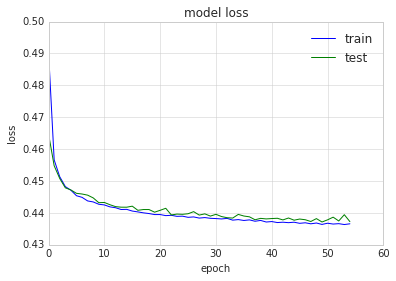

Fold took 677.476s

Running fold 2 / 3
.
1 New best found: 0.45996870394
.
2 New best found: 0.452509129808
.
3 New best found: 0.44769103889
.
4 New best found: 0.447642261554
.
5 New best found: 0.447054029014
.
6 New best found: 0.444863665702
.
7 New best found: 0.444511643403
..
9 New best found: 0.4430029712
..
11 New best found: 0.441995403729
.
12 New best found: 0.44126407323
...
15 New best found: 0.44112474598
..
17 New best found: 0.440820878312
.
18 New best found: 0.440296386501
..
20 New best found: 0.439869518483
...
23 New best found: 0.439530528902
..
25 New best found: 0.439390840093
...
28 New best found: 0.439175365628
.....Early stopping after 33 epochs
Score is: {'loss': 0.4391753656280053, 'AUC': 0.12475543128657385, 'cut': 0.0, 'wAUC': 0.12475543128657385, 'AMS': 0}


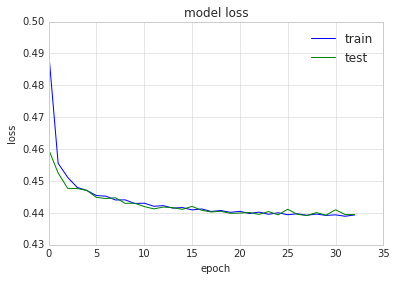

Fold took 423.421s

Running fold 3 / 3
.

In [ ]:
results, histories = batchTrainClassifier(trainData, 3, getModel, newModelArgs,
                                          trainParams, trainOnWeights=False, maxEpochs=200,
                                          cosAnnealMult=0, reduxDecay=-1,  # this line added
                                          patience=5, verbose=1, amsSize=-1, binary=True,
                                          #plotLR=plot_while_training, # plotMomentum=plot_while_training, 
                                          plot=plotLoss, 
                                          stopIfStallingTest=-1,
                                         )
n = name_pretrain+'_model_step3p1'
#model.save(n+'.h5')
with open(n+'.pkl', 'w') as f:
    pickle.dump((results, histories), f)
print('Results saved in = ' + n+'.pkl')

In [ ]:
# Open model
n = name_pretrain+'_model_step3p1'
#model = load_model(n+'.h5', custom_objects=new_loss_functions)
with open(n+'.pkl') as f:
    results, histories = pickle.load(f)

In [ ]:
for i in range(len(histories)):
    plotLoss(histories[i])

## Construct ensemble

In [ ]:
with open('train_weights/resultsFile.pkl', 'rb') as fin:
    results = pickle.load(fin)

In [ ]:
ensembleSize=10
ensembleMode='loss'
ensemble, weights = assembleEnsemble(
    results, ensembleSize, ensembleMode, compileArgs, custom_objects=new_loss_functions)

## Response on validation data with ensembling
(prediction with ensembling)

In [ ]:
valData = BatchYielder(h5py.File(dirLoc + 'test.hdf5', "r+"))

In [ ]:
%%time
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=1, verbose=1, nOut=1)

In [ ]:
print('Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source))))

# Plotting

(600000, 'candidates loaded')


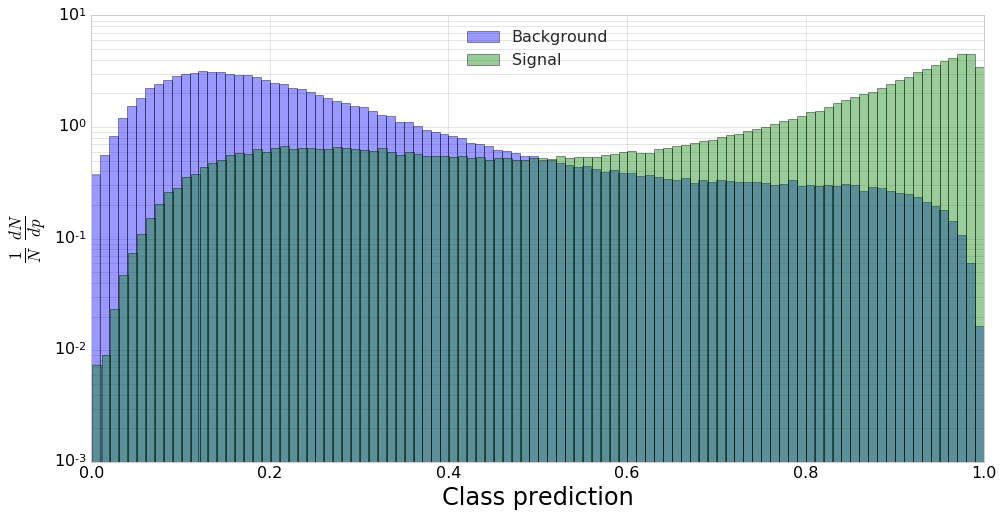

In [33]:
# TODO log-x
d = convertToDF(valData.source)

s_norm = s_exp/np.sum(d['gen_weight'][d['gen_target']==1])
b_norm = b_exp/np.sum(d['gen_weight'][d['gen_target']==0])

d['final_weight']                         = d['gen_weight']*s_norm
d.loc[d['gen_target']==0, 'final_weight'] = d['gen_weight']*b_norm

bkg_sig_dfs = [
    d[d['gen_target']==0],
    d[d['gen_target']==1],
]
getClassPredPlot(bkg_sig_dfs, weightName='final_weight',n_bins=100)

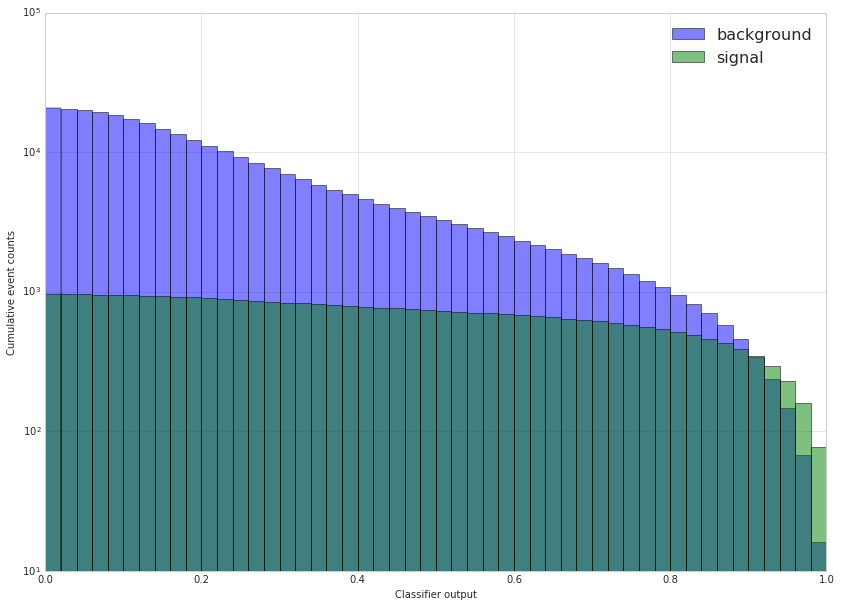

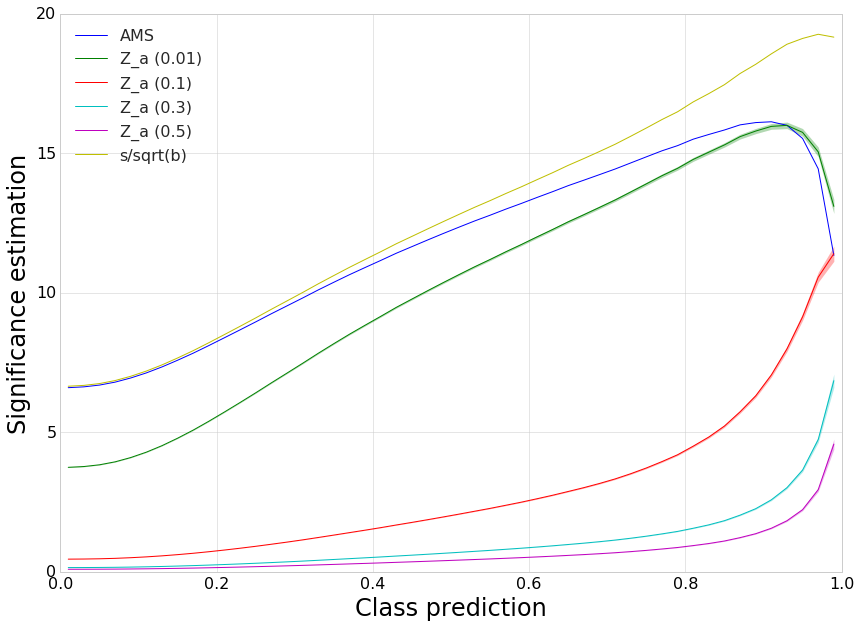

In [34]:
src = valData
#src = testData
from numpy import sqrt, log, power

def get_asimov(systematic):
    return lambda s,b: (Z_asimov(s,b, systematic), 
                        eZ_asimov(s,sqrt(s/s_norm)*s_norm,b,sqrt(b/b_norm)*b_norm,systematic))

h1 = plotSignificanceEstimate(
    d, 
    {
        #'s/sqrt(b)': lambda s,b: s/np.sqrt(b),
        's/sqrt(b)': lambda s,b: s/np.sqrt(b),
        'Z_a (0.5)': get_asimov(0.5),
        'Z_a (0.3)': get_asimov(0.3),
        'Z_a (0.1)': get_asimov(0.1),
        'Z_a (0.01)': get_asimov(0.01),
        'AMS': AMS,
#        'asimov err': lambda s,b: eZ(s,sqrt(s),b,sqrt(b)),
    },
    weightName='final_weight',
    figsize=(14, 10),
    nBins=50,
)

## Code dump

In [ ]:
def newGetModel(**modelArgs):
    new_model = getModel(**modelArgs)
    old_model =  load_model('PRETRAINGING.h5', custom_objects=new_loss_functions)
    new_model.set_weights(old_model.get_weights())
    return new_model